# Sphere swelling

- Swelling of a sphere
- This is a three-dimensional simulation

Accompanies the book, 
- L. Anand, E.M. Stewart, S.A. Chester. _Introduction to coupled theories in solid mechanics_. 2025, in preparation.


# Degrees of freedom
- Displacement: u
- pressure: p
- chemical potential: mu
- concentration: c

# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Amount of substance: mol
- Species concentration: mol/mm^3
- Chemical potential: milliJ/mol
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s
- Gas constant: microJ/(mol K)

### Software:
- Dolfinx v0.8.0

Eric Stewart and Lallit Anand  

ericstew@mit.edu and anand@mit.edu   

June 2024

# Import modules

In [19]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [20]:
# Sphere radius
R0 = 2.5    # mm, external radius


# Read in the 3D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/sphere_v3.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 2D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_sphere_v3.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell number indices**

In [21]:
top_imap = domain.topology.index_map(2)      # index map of 3D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indices

[12]


**Print out the unique facet index numbers**

In [22]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9)  
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 
# //+
# Physical Volume("totVol", 12) 

[ 8  9 10 11]


**Visualize reference configuration**

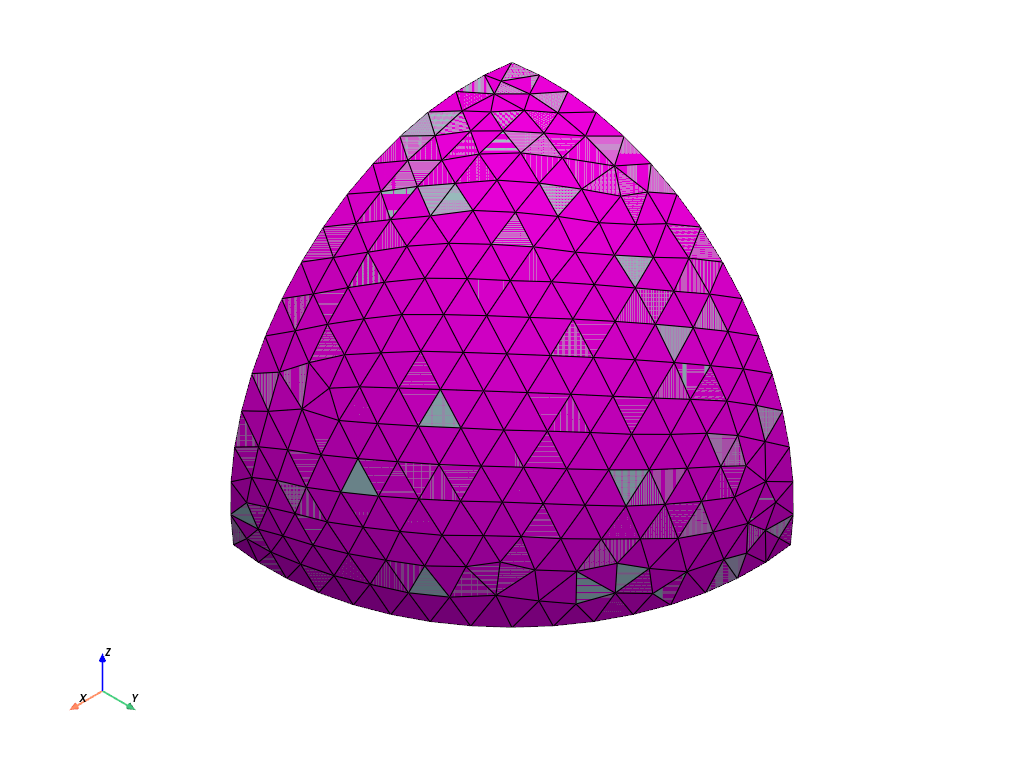

In [23]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter.add_mesh(grid, show_edges=True)    #, opacity=0.25) 

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9) 
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 
# //+
# Physical Volume("totVol", 12) 

# Add colored 2D surfaces for the named surfaces
ybot= pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==8]) )
zbot = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==9]) )
xbot = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==10]) )
outer_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==11]) )
#
actor  = plotter.add_mesh(ybot,      show_edges=True,color="blue")  
actor2 = plotter.add_mesh(zbot,      show_edges=True,color="red")  
actor3 = plotter.add_mesh(xbot,      show_edges=True,color="green")  
actor3 = plotter.add_mesh(outer_surf,show_edges=True,color="magenta") 


labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
plotter.add_axes(**labels)

plotter.screenshot("results/sphere_mesh.png")

from IPython.display import Image
Image(filename='results/sphere_mesh.png') 

# #Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("sphere_mesh.png")


## Define boundary and volume integration measure

In [24]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters

In [25]:
# Set the locking stretch to a large number to model a Neo-Hookean material
#
Gshear_0= Constant(domain,PETSc.ScalarType(1000.0))         # Shear modulus, kPa
lambdaL = Constant(domain,PETSc.ScalarType(100))            # Locking stretch  fro a Neo-Hookean material
Kbulk   = Constant(domain,PETSc.ScalarType(1000*Gshear_0))  # Bulk modulus, kPa
Omega   = Constant(domain,PETSc.ScalarType(1.00e5))         # Molar volume of fluid
D       = Constant(domain,PETSc.ScalarType(5.00e-3))        # Diffusivity
chi     = Constant(domain,PETSc.ScalarType(0.1))            # Flory-Huggins chi parameter
theta0  = Constant(domain,PETSc.ScalarType(298) )           # Reference temperature
R_gas   = Constant(domain,PETSc.ScalarType(8.3145e6))       # Gas constant
RT      = Constant(domain,PETSc.ScalarType(8.3145e6*theta0))
#
phi0    = Constant(domain,PETSc.ScalarType(0.999))                               # Initial polymer volume fraction
mu0     = Constant(domain,PETSc.ScalarType(ln(1.0-phi0) + phi0 + chi*phi0*phi0)) # Initial chemical potential
c0      = Constant(domain,PETSc.ScalarType((1/phi0) - 1))                        # Initial concentration

# Simulation time-control related parameters

In [26]:
t    = 0.0        # initialization of time
Ttot = 3600*6     # total simulation time 
ttd  = 300        # Decay time constant
dt   = 100        # Fixed step size

# Time step field, constant within domain
dk = Constant(domain, PETSc.ScalarType(dt))

# Boundary condition expression for increasing  the chemical potential
#
def muRamp(t):
    return mu0*exp(-t/ttd)

# Function spaces

In [27]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For pressure, chemical potential and  species concentration
#                                      
TH = mixed_element([U2, P1, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)        # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, mu, c = split(w)  # displacement u, pressure p, chemical potential mu, and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, mu_old, c_old = split(w_old)   

# Define test functions    
u_test, p_test,  mu_test, c_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Assign initial  normalized chemical potential mu0 to the domain
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  mu0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), mu0))  

# Assign initial  value of normalized concentration c0 to the domain
w.sub(3).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(3).interpolate(lambda x: np.full((x.shape[1],), c0))     

# Subroutines for kinematics and constitutive equations

In [28]:
#---------------------------------------------------
# Deformation gradient 
#---------------------------------------------------
def F_calc(u):
    
    Id = Identity(3)          # 3D Identity tensor
    
    F = Id + grad(u)            # 3D Deformation gradient
    
    return F

#---------------------------------------------------
# Effective stretch lambdaBar
#---------------------------------------------------
def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    I1 = tr(C)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

#---------------------------------------------------
# Calculate zeta
#---------------------------------------------------
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#---------------------------------------------------
# Calculate zeta0
#---------------------------------------------------
def zeta0_calc():
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta0 = (lambdaL/3)*beta0
    return zeta0

#---------------------------------------------------
# Subroutine for calculating the elastic jacobian Je
#---------------------------------------------------
def Je_calc(u,c):
    F = F_calc(u)  
    detF = det(F)   
    #
    detFs = 1.0 + c          # = Js
    Je    = (detF/detFs)     # = Je
    return   Je    

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u,p):
    F     = F_calc(u)
    zeta  = zeta_calc(u)
    zeta0 = zeta0_calc()
    Piola = (zeta*F - zeta0*inv(F.T) ) - J*p*inv(F.T)/Gshear_0
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the normalized species flux
#--------------------------------------------------------------
def Flux_calc(u, mu, c):
    F = F_calc(u) 
    #
    Cinv = inv(F.T*F) 
    #
    Mob = (D*c)/(Omega*RT)*Cinv
    #
    Jmat = - RT* Mob * grad(mu)
    return Jmat

# Evaluate kinematics and constitutive relations

In [29]:
# Kinematics
F = F_calc(u)
J = det(F)  # Total volumetric jacobian
#
lambdaBar = lambdaBar_calc(u)
#
# Elastic volumetric Jacobian
Je     = Je_calc(u,c)                    
Je_old = Je_calc(u_old,c_old)

#  Normalized Piola stress
Piola = Piola_calc(u, p)

#  Normalized species  flux
Jmat = Flux_calc(u, mu, c)


# Weak forms

In [30]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure variable (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Auxiliary variable (test fxn: c)

# Time step field, constant within body
#dk = Constant(domain, PETSc.ScalarType(dt))

# The weak form for the equilibrium equation
Res_0 = inner(Piola, grad(u_test) )*dx

# The weak form for the auxiliary pressure variable definition
Res_1 = dot((p*Je/Kbulk + ln(Je)) , p_test)*dx

# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*dx \
        -  Omega*dot(Jmat , grad(mu_test) )*dx

# The weak form for the concentration
fac = 1/(1+c)
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac)
fac2 = - (Omega*Je/RT)*p  
fac3 = - (1./2.) * (Omega/(Kbulk*RT)) * ((p*Je)**2.0) 
fac4 = fac1 + fac2 + fac3
#
Res_3 = dot(fac4, c_test)*dx
        
# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [31]:
# results file name
results_name = "gel_sphere_swell"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(3,))  # For displacement
P0 = element("DG", domain.basix_cell(), 1)              # For  pressure, chemical potential, and concentration 
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"

# computed fields to write to output file
phi = 1/(1+c)
phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(phi,V1.element.interpolation_points())

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola[0,0],V1.element.interpolation_points())
#
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola[1,1],V1.element.interpolation_points())
#
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola[2,2],V1.element.interpolation_points())

# Mises stress
T   = Piola*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, mu_vis, c_vis, phi_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       mu_vis.interpolate(w.sub(2))
       c_vis.interpolate(w.sub(3))
       phi_vis.interpolate(phi_expr)
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)

       # Write output fields
       file_results.write(t) 
        

# Analysis Step

In [32]:
# Give the step a descriptive name
step = "Swell"

## Boundary conditions

In [33]:
# Constant for applied  chemical potential
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9) 
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 
 

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(10))
#
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(8))
#
zBot_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(9))
#
outer_mu_dofs = fem.locate_dofs_topological(ME.sub(2),       facet_tags.dim, facet_tags.find(11))


# Dirichlet BCs for displacement
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))    # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))    # u2 fix - yBot
bcs_3 = dirichletbc(0.0, zBot_u3_dofs, ME.sub(0).sub(2))    # u3 fix - zBot

# Dirichlet BCs for chemical potential
bcs_4 = dirichletbc(mu_cons, outer_mu_dofs, ME.sub(2))      # mu_cons - outer



# Complete set of Dirichlet bcs
bcs = [bcs_1, bcs_2, bcs_3, bcs_4]


## Define the nonlinear variational problem

In [34]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)
# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)

# Solver parameters
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" #  
opts[f"{option_prefix}pc_type"] = "lu"       # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


# Initialize arrays for storing output history

In [35]:
# # Arrays for storing output history
# totSteps = 100000
# timeHist0 = np.zeros(shape=[totSteps])
# timeHist1 = np.zeros(shape=[totSteps]) 
# timeHist2 = np.zeros(shape=[totSteps]) 
# timeHist3 = np.zeros(shape=[totSteps])
# #
# timeHist3[0] = mu0 # Initialize the chemical potential

# Initialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [36]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
    
    # # smaller time-step needed for initiation of buckling
    # if (t>=500 and t<=1000): 
    #     dt = 5
    #     dk = Constant(domain, PETSc.ScalarType(dt))
    # else:
    #     dt = 25
    #     dk = Constant(domain, PETSc.ScalarType(dt))
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    mu_cons.value = float(muRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Swell | Increment: 1, Iterations: 6
      Simulation Time: 100.0 s  of  21600 s

Step: Swell | Increment: 2, Iterations: 6
      Simulation Time: 200.0 s  of  21600 s

Step: Swell | Increment: 3, Iterations: 5
      Simulation Time: 300.0 s  of  21600 s

Step: Swell | Increment: 4, Iterations: 5
      Simulation Time: 400.0 s  of  21600 s

Step: Swell | Increment: 5, Iterations: 5
      Simulation Time: 500.0 s  of  21600 s

Step: Swell | Increment: 6, Iterations: 5
      Simulation Time: 600.0 s  of  21600 s

Step: Swell | Increment: 7, Iterations: 5
      Simulation Time: 700.0 s  of  21600 s

Step: Swell | Increment: 8, Iterations: 5
      Simulation Time: 800.0 s  of  21600 s

Step: Swell | Increment: 9, Iterations: 5
      Simulation Time: 900.0 s  of  21600 s

Step: Swell | Increment: 10, Iterations: 5
      Simulation Time: 1000.0 s  of  21600 s

Step: Swell | Increment: 11, Iteratio